In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
train.head()

(300000, 25)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [2]:
%%time

# Subset
target = train['target']
train_id = train['id']
test_id = test['id']
train.drop(['target', 'id'], axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

print(train.shape)
train.head()

(300000, 23)
Wall time: 51.9 ms


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8


In [3]:
# Transfer the cyclical features into two dimensional sin-cos features
# https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

train = cyclical_encode(train, 'day', 7)
test = cyclical_encode(test, 'day', 7) 

train = cyclical_encode(train, 'month', 12)
test = cyclical_encode(test, 'month', 12)

train.drop(['day', 'month'], axis=1, inplace=True)
test.drop(['day', 'month'], axis=1, inplace=True)

print(train.shape)
train.head()

(300000, 25)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2,Grandmaster,Cold,h,D,kr,9.749279e-01,-0.222521,0.866025,0.500000
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,1,Grandmaster,Hot,a,A,bF,-2.449294e-16,1.000000,-0.866025,-0.500000
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,1,Expert,Lava Hot,h,R,Jc,-2.449294e-16,1.000000,0.866025,0.500000
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,1,Grandmaster,Boiling Hot,i,D,kW,9.749279e-01,-0.222521,0.500000,0.866025
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,1,Grandmaster,Freezing,a,R,qP,-2.449294e-16,1.000000,-0.866025,-0.500000


In [4]:
# First, I encode ord_1 to ord_4 since the numbers of their unique values are small 
mapper_ord_1 = {'Novice': 1, 
                'Contributor': 2,
                'Expert': 3, 
                'Master': 4, 
                'Grandmaster': 5}

mapper_ord_2 = {'Freezing': 1, 
                'Cold': 2, 
                'Warm': 3, 
                'Hot': 4,
                'Boiling Hot': 5, 
                'Lava Hot': 6}

mapper_ord_3 = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 
                'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15}

mapper_ord_4 = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 
                'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
                'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 
                'W': 23, 'X': 24, 'Y': 25, 'Z': 26}

# https://www.kaggle.com/asimandia/let-s-try-some-feature-engineering
traintest = pd.concat([train, test])
train['ord_1_count'] = train['ord_1'].map(traintest['ord_1'].value_counts().to_dict())
test['ord_1_count'] = test['ord_1'].map(traintest['ord_1'].value_counts().to_dict())

for col, mapper in zip(['ord_1', 'ord_2', 'ord_3', 'ord_4'], [mapper_ord_1, mapper_ord_2, mapper_ord_3, mapper_ord_4]):
    train[col+'_oe'] = train[col].replace(mapper)
    test[col+'_oe'] = test[col].replace(mapper)
    train.drop(col, axis=1, inplace=True)
    test.drop(col, axis=1, inplace=True)

print(train.shape)
train.head()

(300000, 26)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,ord_5,day_sin,day_cos,month_sin,month_cos,ord_1_count,ord_1_oe,ord_2_oe,ord_3_oe,ord_4_oe
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,kr,9.749279e-01,-0.222521,0.866025,0.500000,129143,5,2,8,4
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,bF,-2.449294e-16,1.000000,-0.866025,-0.500000,129143,5,4,1,1
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,Jc,-2.449294e-16,1.000000,0.866025,0.500000,41709,3,6,8,18
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,kW,9.749279e-01,-0.222521,0.500000,0.866025,129143,5,5,9,4
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,qP,-2.449294e-16,1.000000,-0.866025,-0.500000,129143,5,1,1,18


In [5]:
# # Then encode 'ord_5' using ACSII values

# Option 1: Add up the indices of two letters in string.ascii_letters
train['ord_5_oe_add'] = train['ord_5'].apply(lambda x:sum([(string.ascii_letters.find(letter)+1) for letter in x]))
test['ord_5_oe_add'] = test['ord_5'].apply(lambda x:sum([(string.ascii_letters.find(letter)+1) for letter in x]))

# # Option 2: Join the indices of two letters in string.ascii_letters
# train['ord_5_oe_join'] = train['ord_5'].apply(lambda x:float(''.join(str(string.ascii_letters.find(letter)+1) for letter in x)))
# test['ord_5_oe_join'] = test['ord_5'].apply(lambda x:float(''.join(str(string.ascii_letters.find(letter)+1) for letter in x)))

# # # Option 3: Split 'ord_5' into two new columns using the indices of two letters in string.ascii_letters, separately
# train['ord_5_oe1'] = train['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))
# test['ord_5_oe1'] = test['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))

# train['ord_5_oe2'] = train['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))
# test['ord_5_oe2'] = test['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))

# # Option 4: Simply sort their values by string
# # https://www.kaggle.com/c/cat-in-the-dat/discussion/105702#latest-607652
# ord_5 = sorted(list(set(train['ord_5'].values)))
# ord_5 = dict(zip(ord_5, range(len(ord_5))))
# train.loc[:, 'ord_5'] = train['ord_5'].apply(lambda x: ord_5[x]).astype(float)
# test.loc[:, 'ord_5'] = test['ord_5'].apply(lambda x: ord_5[x]).astype(float)

# Option 4 need keep ord_5. the other options are free to remove ord_5.
train.drop('ord_5', axis=1, inplace=True)
test.drop('ord_5', axis=1, inplace=True)

print(train.shape)
train.head()

(300000, 26)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,day_sin,day_cos,month_sin,month_cos,ord_1_count,ord_1_oe,ord_2_oe,ord_3_oe,ord_4_oe,ord_5_oe_add
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,9.749279e-01,-0.222521,0.866025,0.500000,129143,5,2,8,4,29
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,-2.449294e-16,1.000000,-0.866025,-0.500000,129143,5,4,1,1,34
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,-2.449294e-16,1.000000,0.866025,0.500000,41709,3,6,8,18,39
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,9.749279e-01,-0.222521,0.500000,0.866025,129143,5,5,9,4,60
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,-2.449294e-16,1.000000,-0.866025,-0.500000,129143,5,1,1,18,59


In [6]:
# Transfer the dtypes of encoded ordinal features into float64
for col in ['ord_0', 'ord_1_oe', 'ord_2_oe', 'ord_3_oe', 'ord_4_oe', 'ord_5_oe_add', 'ord_1_count']: 
    train[col]= train[col].astype('float64')
    test[col]= test[col].astype('float64')
    
print(train.shape)
train.head()

(300000, 26)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,day_sin,day_cos,month_sin,month_cos,ord_1_count,ord_1_oe,ord_2_oe,ord_3_oe,ord_4_oe,ord_5_oe_add
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,9.749279e-01,-0.222521,0.866025,0.500000,129143.0,5.0,2.0,8.0,4.0,29.0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,-2.449294e-16,1.000000,-0.866025,-0.500000,129143.0,5.0,4.0,1.0,1.0,34.0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,-2.449294e-16,1.000000,0.866025,0.500000,41709.0,3.0,6.0,8.0,18.0,39.0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,9.749279e-01,-0.222521,0.500000,0.866025,129143.0,5.0,5.0,9.0,4.0,60.0
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,-2.449294e-16,1.000000,-0.866025,-0.500000,129143.0,5.0,1.0,1.0,18.0,59.0


## The other encoding methods have been taken. Will compare it later.

In [7]:
# Do some ordinal encoding
# from sklearn.preprocessing import OrdinalEncoder

# ordinal_columns = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4']
# oe = OrdinalEncoder()
# train_oe = oe.fit_transform(train[ordinal_columns])
# test_oe = oe.transform(test[ordinal_columns])

# ordinal_columns_oe = ['ord_0_oe_skl', 'ord_1_oe_skl', 'ord_2_oe_skl', 'ord_3_oe_skl', 'ord_4_oe_skl', 'ord_5_oe_skl']
# train = pd.concat([train, pd.DataFrame(train_oe, columns=ordinal_columns_oe)], axis=1)
# test = pd.concat([test, pd.DataFrame(test_oe, columns=ordinal_columns_oe)], axis=1)

# train.drop(ordinal_columns, axis=1, inplace=True)
# test.drop(ordinal_columns, axis=1, inplace=True)

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
from catboost import Pool, CatBoostClassifier
from category_encoders import TargetEncoder

# Specify the non-float features as categorical to the model.
categorical_features_indices = np.where(test.dtypes != np.float)[0]
print('Categorial Feature Indices: ', categorical_features_indices)

Categorial Feature Indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [9]:
%%time

# Model
def run_cv_model(categorical_indices, train, test, target, model_fn, params={}, eval_fn=None, label='model', n_folds=5):
    kf = KFold(n_splits=n_folds)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = test.columns
    i = 1
    for dev_index, val_index in fold_splits:
        print('-------------------------------------------')
        print('Started ' + label + ' fold ' + str(i) + f'/{n_folds}')
        dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
        dev_y, val_y = target.iloc[dev_index], target.iloc[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, fi = model_fn(categorical_indices, dev_X, dev_y, val_X, val_y, test, params2)
        feature_importances[f'fold_{i}'] = fi
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score), '\n')
        i += 1
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / n_folds
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores, 'fi': feature_importances}
    return results


def runCAT(categorical_indices, train_X, train_y, test_X, test_y, test_X2, params):
    # Pool the data and specify the categorical feature indices
    print('Pool Data')
    _train = Pool(train_X, label=train_y, cat_features = categorical_indices)
    _valid = Pool(test_X, label=test_y, cat_features = categorical_indices)    
    print('Train CAT')
    model = CatBoostClassifier(**params)
    fit_model = model.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=1000,
                          plot=False)
    feature_im = fit_model.feature_importances_
    print('Predict 1/2')
    pred_test_y = fit_model.predict_proba(test_X)[:, 1]
    print('Predict 2/2')
    pred_test_y2 = fit_model.predict_proba(test_X2)[:, 1]
    return pred_test_y, pred_test_y2, feature_im


# Use some baseline parameters
cat_params = {'loss_function': 'CrossEntropy', 
              'eval_metric': "AUC",
              'task_type': "GPU",
              'learning_rate': 0.01,
              'iterations': 10000,
              'random_seed': 42,
              'od_type': "Iter",
#               'bagging_temperature': 0.2,
#               'depth': 10,
              'early_stopping_rounds': 500,
             }

n_folds = 5
results = run_cv_model(categorical_features_indices, train, test, target, runCAT, cat_params, auc, 'cat', n_folds=n_folds)

-------------------------------------------
Started cat fold 1/5
Pool Data
Train CAT
0:	learn: 0.6855367	test: 0.6866221	best: 0.6866221 (0)	total: 71ms	remaining: 11m 50s
1000:	learn: 0.7770666	test: 0.7803041	best: 0.7803041 (1000)	total: 34.3s	remaining: 5m 8s
2000:	learn: 0.7836338	test: 0.7848716	best: 0.7848717 (1999)	total: 1m 8s	remaining: 4m 33s
3000:	learn: 0.7873622	test: 0.7862432	best: 0.7862447 (2998)	total: 2m 34s	remaining: 5m 59s
4000:	learn: 0.7903400	test: 0.7869242	best: 0.7869257 (3996)	total: 5m 6s	remaining: 7m 39s
5000:	learn: 0.7930011	test: 0.7872886	best: 0.7872896 (4993)	total: 7m 39s	remaining: 7m 38s
6000:	learn: 0.7955242	test: 0.7874753	best: 0.7874753 (6000)	total: 11m 45s	remaining: 7m 49s
7000:	learn: 0.7979222	test: 0.7876188	best: 0.7876220 (6985)	total: 12m 36s	remaining: 5m 24s
8000:	learn: 0.8002760	test: 0.7876645	best: 0.7876655 (7937)	total: 13m 15s	remaining: 3m 18s
9000:	learn: 0.8025795	test: 0.7877072	best: 0.7877109 (8831)	total: 13m 53s	

In [10]:
%%time

# Make submission
submission = pd.DataFrame({'id': test_id, 'target': results['test']})
submission.to_csv('submission.csv', index=False)

Wall time: 413 ms


In [11]:
# Calculate the average feature importance for each feature
feature_importances = results['fi']
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_folds)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')
feature_importances.sort_values(by='average', ascending=False).head()

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
24,ord_4_oe,9.909969,9.687561,9.880643,10.046932,9.786439,9.862309
25,ord_5_oe_add,9.377443,9.916840,9.695705,9.640774,9.738935,9.673939
22,ord_2_oe,8.510223,8.314709,8.604842,8.735454,8.603879,8.553822
23,ord_3_oe,7.394388,7.192372,7.400487,7.634898,7.335493,7.391528
21,ord_1_oe,6.198802,6.271309,6.469284,6.405747,6.464927,6.362014


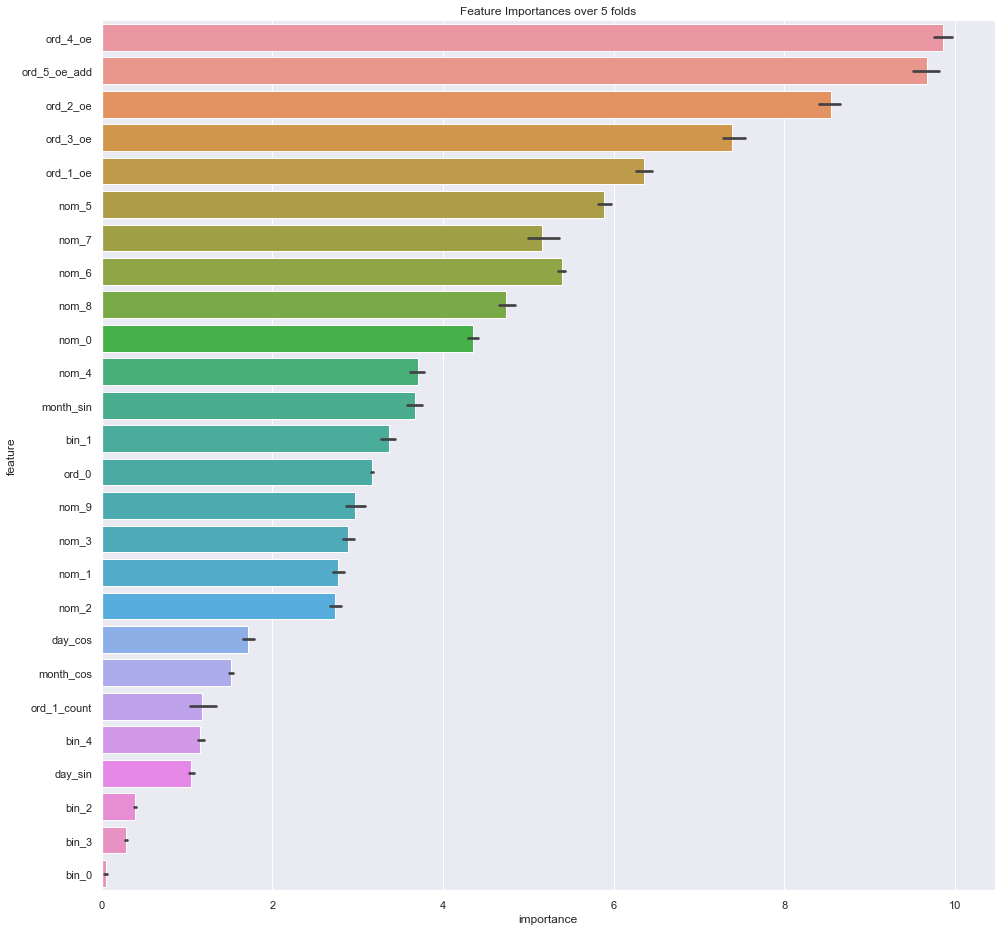

In [12]:
# Plot the feature importances with min/max/average using seaborn
feature_importances_flatten = pd.DataFrame()
for i in range(1, len(feature_importances.columns)-1):
    col = ['feature', feature_importances.columns.values[i]]
    feature_importances_flatten = pd.concat([feature_importances_flatten, feature_importances[col].rename(columns={f'fold_{i}': 'importance'})], axis=0)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances_flatten.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature Importances over {} folds'.format(n_folds))  
plt.savefig("feature_importances.png")